### 1. The KITTI Dataset - Introduction

* The KITTI dataset has been recorded from a moving platform (Fig. 1) while driving in and around Karlsruhe, Germany.
* It includes camera images, laser scans (LIDAR), high-precision GPS measurements and IMU accelerations from a combined GPS/IMU system.
* For comprihensive technical details on the raw data check: [Vision meets Robotics: The KITTI Dataset](https://www.cvlibs.net/publications/Geiger2013IJRR.pdf)

#### 1.1 Sensor Setup

<div align="center">
  <img src="./images/sensor_setup.png" width="40%">
</div>

#### 1.2 Zip File Structure

<div align="center">
  <img src="./images/file_struc.png" width="40%">
</div>

### 2. How we'll explore the KITTI Dataset

#### Phase 1: Data Analysis
- **Camera Data**: Load and visualize 4 camera streams (2 grayscale, 2 color)
- **LiDAR Data**: Process and visualize Velodyne point clouds
- **Transforming Coordinates**: Project 3D points onto camera images using calibration
- **Annotations**: Parse trackelets.xml and overlay bounding boxes
- **Navigation**: Process GPS/IMU data and project to image space
- **Tracking**: Implement basic object tracking across frames

#### Phase 2: Package Development
- **KITTI Toolkit**: Create structured Python package for data loading and visualization

#### 2.1 Data Analysis

We'll start exploring the sequence **2011_09_26_drive_0005** (avalaible at kitti raw data website in the "City" category):

Description:
- 2011_09_26_drive_0005 (0.6 GB)
- Length: 160 frames (00:16 minutes)
- Image resolution: 1392 x 512 pixels
- Labels: 9 Cars, 3 Vans, 0 Trucks, 2 Pedestrians, 0 Sitters, 1 Cyclists, 0 Trams, 0 Misc

In [1]:
# imports
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt

import os
from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### 2.1.1 Camera Data

In [2]:
# Define base path environment variable
with open("./env_vars.txt", "r") as f:
    BASE_PATH = f.readlines()[0].split("=")[1].strip()

In [3]:
# List of sensors (4 video cameras, GPU/IMU and Velodyne)
path = os.path.join(BASE_PATH, "LIDAR/KITTI/dataset/raw/city/2011_09_26/2011_09_26_drive_0005_sync/") # using synchronized and rectified data
sensors = os.listdir(path)
print(sensors)

['oxts', 'image_00', 'image_01', 'image_02', 'image_03', 'velodyne_points']


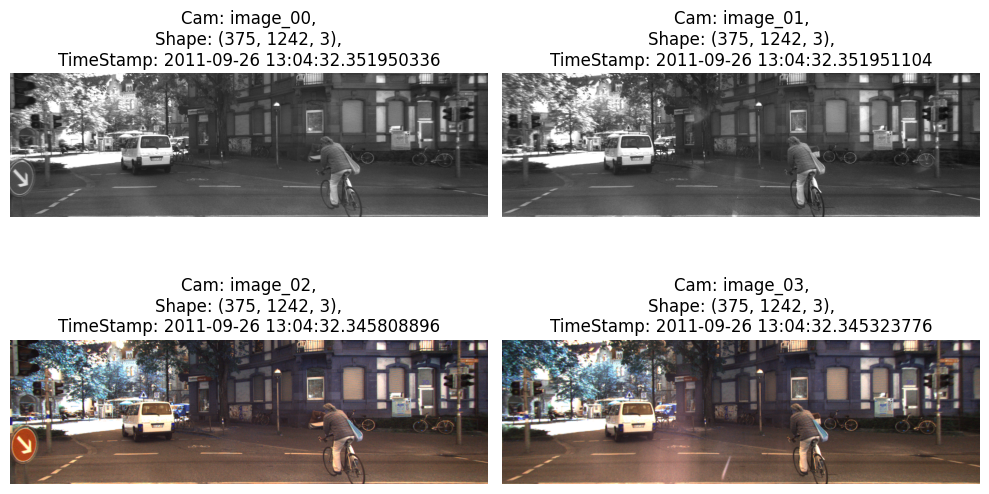

In [48]:
# A function to read and display a given frame from each of the video cameras sensors

def load_and_display_frame(seq_path: str, frame_number: int) -> None:
    '''
    Reads and displays the four frames from the 4 video cameras
    '''

    _, axes = plt.subplots(2,2, figsize = (10,6))
    sensors = os.listdir(seq_path)
    i = 0

    cam_imgs = []

    for sensor in sensors:
        if sensor.startswith("image"):
            # get time stamp
            txtfile = [f for f in os.listdir(os.path.join(seq_path, sensor)) if f.endswith('.txt')][0]
            with open(os.path.join(seq_path, sensor, txtfile), 'r') as f:
                timestamp = f.readlines()[frame_number].strip()

            cam_path = os.path.join(seq_path, sensor, "data/")
            img_pth = os.path.join(cam_path, os.listdir(cam_path)[frame_number])

            # read image
            img = cv2.imread(img_pth)

            cam_imgs.append(img)
            # display image
            ax = axes[i//2, i%2]
            ax.imshow(img/255)
            ax.set_title(f"Cam: {sensor},\nShape: {img.shape},\nTimeStamp: {timestamp}")
            ax.axis("off")

            i+=1
    plt.tight_layout()
    plt.show()

    return cam_imgs
            
FRAME_NUMBER = 0

cam_imgs = load_and_display_frame(path, FRAME_NUMBER)

#### 2.1.2 LiDAR Data

In [25]:
# Read and display point cloud data for frame 0 in the given sequence
def load_and_display_pcd(seq_path: str, frame_number: int) -> None:
    '''
    Reads and displays the pcd for the given frame number and sequence from the velodyne sensor
    '''

    for sensor in sensors:

        if sensor.startswith('velo'):
            # get the three time stamps (rolling shutter: start spin, end spin, camera trigger)
            txtfiles = [os.path.join(seq_path, sensor, f) for f in os.listdir(os.path.join(seq_path, sensor)) if f.endswith('.txt')]
            timestamps = [open(f, 'r').readlines()[0].strip() for f in txtfiles]
            print(timestamps)

            # get pcd data
            velo_path = os.path.join(seq_path, sensor, "data/")
            pcd_path = os.path.join(velo_path, os.listdir(velo_path)[frame_number])
            pcd = np.fromfile(pcd_path,  dtype=np.float32)
            pcd = pcd.reshape((-1,4)) # x, y, z and reflectance

            # Convert to open3d point cloud
            pcd_np = pcd[:, :3]

            pcd_o3d = o3d.geometry.PointCloud() # create point cloud object
            pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)

            # visualize:
            # o3d.visualization.draw_geometries([pcd_o3d])
            
            return pcd_np


pcd_np= load_and_display_pcd(path, FRAME_NUMBER)

['2011-09-26 13:04:32.335337762', '2011-09-26 13:04:32.283701593', '2011-09-26 13:04:32.386973931']


Zoomed in SS of the point cloud: 

<div align="center">
  <img src="./images/pcd_seq_2011_09_26_drive_0005_frame_100.jpg" width="60%">
</div>

#### 2.1.3 Transforming Coordinates

Using the intrinsic and extrinsic parameters provided in the calibration files, we can project 3D points from the LiDAR onto the camera images and vice versa.

1. Generate a colored point cloud by projecting pcd to RGB image. Read the calibration files for parameters.
   1. `calib_velo_to_cam.txt`: Has the extrinsic parameters (Rotation Matrix and Translation Vector) to transform Velo coordinates (3D) to reference camera coordinates (camera 0 3D).
   2. `calib_cam_to_cam.txt`: Has the projection matrix to transform the reference camera coordinates (camera 0 3D) to Image plane coordinates of another camera (pixel space).
   
TODO: Learn about rectification and simple stereo

A 3D point **x** in Velodyne coordinates gets projected to a point **y** in the i'th camera image as:

$$
\mathbf{y} = \mathbf{P}^{(i)} \cdot \mathbf{R}_{\text{rect}}^{(0)} \cdot \mathbf{T}_{\text{velo}}^{\text{cam}} \cdot \mathbf{x}
$$

Where:

- $ \mathbf{P}^{(i)} $: Projection matrix for the i'th camera.
- $ \mathbf{R}_{\text{rect}}^{(0)} $: Rectification matrix for the 0'th camera.
- $ \mathbf{T}_{\text{velo}}^{\text{cam}} $: Transformation matrix from Velodyne to camera coordinates.
- $ \mathbf{x} $: 3D point in Velodyne coordinates.

In [15]:
# Get calibration data
calib_path = os.path.join(BASE_PATH, "LIDAR/KITTI/dataset/raw/city/2011_09_26/2011_09_26_calib/")
for f in os.listdir(calib_path):
    print("-"*8 + f"\n\n{f.split(".")[0]}\n", "".join(open(os.path.join(calib_path, f), 'r').readlines()))

--------

calib_cam_to_cam
 calib_time: 09-Jan-2012 13:57:47
corner_dist: 9.950000e-02
S_00: 1.392000e+03 5.120000e+02
K_00: 9.842439e+02 0.000000e+00 6.900000e+02 0.000000e+00 9.808141e+02 2.331966e+02 0.000000e+00 0.000000e+00 1.000000e+00
D_00: -3.728755e-01 2.037299e-01 2.219027e-03 1.383707e-03 -7.233722e-02
R_00: 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
T_00: 2.573699e-16 -1.059758e-16 1.614870e-16
S_rect_00: 1.242000e+03 3.750000e+02
R_rect_00: 9.999239e-01 9.837760e-03 -7.445048e-03 -9.869795e-03 9.999421e-01 -4.278459e-03 7.402527e-03 4.351614e-03 9.999631e-01
P_rect_00: 7.215377e+02 0.000000e+00 6.095593e+02 0.000000e+00 0.000000e+00 7.215377e+02 1.728540e+02 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00
S_01: 1.392000e+03 5.120000e+02
K_01: 9.895267e+02 0.000000e+00 7.020000e+02 0.000000e+00 9.878386e+02 2.455590e+02 0.000000e+00 0.000000e+00 1.000000e+00
D_01: -3.644661e-01 1.7900

In [ ]:
# We'll generate a colored point cloud

# 1. Velo to Cam: T*x = R*x + t (3D to 3D)
with open(os.path.join(calib_path, "calib_velo_to_cam.txt"), 'r') as f:
    lines = f.readlines()
    R = np.array([float(n.strip()) for n in lines[1].split(':')[1].split(' ') if n]).reshape(3,3)
    T = np.array([float(n.strip()) for n in lines[2].split(':')[1].split(' ') if n])

pcd_cam0 = (R @ pcd_np.T + T.reshape(-1,1)).T

# 2. Rectification of cam0 (3D to 3D)
with open(os.path.join(calib_path, "calib_cam_to_cam.txt"), 'r') as f:
    line = [l for l in f.readlines() if l.startswith('R_rect_00')][0]
    R_rect_00 = np.array([float(n.strip()) for n in line.split(':')[1].split(' ') if n]).reshape(3,3)

pcd_cam0_rect = (R_rect_00 @ pcd_cam0.T).T

# 3. Projection to one of the colored cam image plane (cam2) (3D to 2D)
with open(os.path.join(calib_path, "calib_cam_to_cam.txt"), 'r') as f:
    line = [l for l in f.readlines() if l.startswith('P_rect_02')][0]
    P_rect_02 = np.array([float(n.strip()) for n in line.split(':')[1].split(' ') if n]).reshape(3,4)


u_tilda = P_rect_02 @ np.vstack([pcd_cam0_rect.T, np.ones(len(pcd_np))])
[u, v] = [u_tilda[0, :]/u_tilda[-1, :], u_tilda[1, :]/u_tilda[-1, :]]

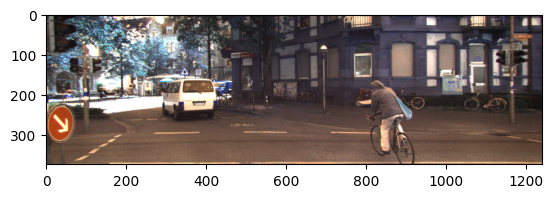

In [54]:
# Get color correspoinding to each (u,v) in the cam2 image
rgb_img = cam_imgs[2]
plt.imshow(rgb_img)
plt.show()

h, w, _ = rgb_img.shape

[u, v] = [u.astype(int).clip(0, w-1), v.astype(int).clip(0, h-1)]

colors = rgb_img[v, u]/255

In [56]:
# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd_np)
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])